In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick

from cycler import cycler
import sys, os, glob
import pytz

from scipy.signal import *
from scipy.stats import *
from scipy.interpolate import *

# use latex fonts/mathematica color scheme
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='Computer Modern Roman')

# cyclers for colors and line styles
line_cycle = cycler('linestyle', ["-","-.","--"])

#color_cycle_trimmed = cycler('color', ["#62ad64", "#9750a1", "#b8893a", "#6778d0", "#b8475f"])
color_cycle = cycler('color', ["#62ad64", "#9750a1", "#b8893a", "#6778d0", "#b8475f"])
clrs = ["#62ad64", "#9750a1", "#b8893a", "#6778d0", "#b8475f"]
clrs2 = ["#e18e9c", "#53c0da", "#c0af6f", "#b5a0dd", "#71c19b"]

In [80]:
# Import external RF data
i = 0
output = {}
for i in range(39):
    if i+1<10:
        f_name = 'unit0'+str(i+1)+'_0dbm.DAT'
        unit_tag = '0'+str(i+1)
    else:
        f_name = 'unit'+str(i+1)+'_0dbm.DAT'
        unit_tag = str(i+1)
    # All frequency ranges are the same
    freq, output[unit_tag], dump = np.genfromtxt(f_name, delimiter = ';',
                                                 skip_header = 29, unpack = True)

In [81]:
# Import VCO data
i = 0
vco = {}
for i in range(39):
    if i+1<10:
        f_name = 'unit0'+str(i+1)+'_vco.DAT'
        unit_tag = '0'+str(i+1)
    else:
        f_name = 'unit'+str(i+1)+'_vco.DAT'
        unit_tag = str(i+1)
    # All frequency ranges are the same
    try:
        freq_vco, vco[unit_tag], dump = np.genfromtxt(f_name, delimiter = ';',
                                                      skip_header = 29, unpack = True)
        vco[unit_tag]+=30
    except (OSError, IOError):
        continue

In [82]:
# Import Harmonic Data
i = 0
Harm = {}
for i in range(3):
    f_name = 'unit29_'+str(i*5)+'dbm.DAT'
    p_tag = '1,'+str(i*5)
    try:
        freq_1st, Harm[p_tag], dump = np.genfromtxt(f_name, delimiter = ';',
                                                      skip_header = 29, unpack = True)
        Harm[p_tag]+=i*5
    except (OSError, IOError):
        continue
for i in range(3):
    f_name = 'unit29_'+str(i*5)+'dbm_2ndH.DAT'
    p_tag = '2,'+str(i*5)
    try:
        freq_2nd, Harm[p_tag], dump = np.genfromtxt(f_name, delimiter = ';',
                                                      skip_header = 29, unpack = True)
        Harm[p_tag]+=i*5
    except (OSError, IOError):
        continue
for i in range(3):
    f_name = 'unit29_'+str(i*5)+'dbm_3rdH.DAT'
    p_tag = '3,'+str(i*5)
    try:
        freq_3rd, Harm[p_tag], dump = np.genfromtxt(f_name, delimiter = ';',
                                                      skip_header = 29, unpack = True)
        Harm[p_tag]+=i*5
    except (OSError, IOError):
        continue

In [83]:
output_2d = np.array([output[tag] for tag in output.keys()])
freq_2d = np.array([freq for tag in output.keys()])

In [147]:
WattLine = np.array([30 for i in range(len(freq))])
WattLine2 = np.array([37 for i in range(len(freq))])

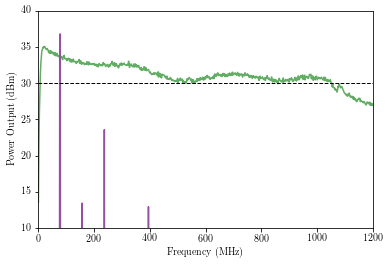

In [65]:
matplotlib.rc('axes', prop_cycle=color_cycle)
tag = '05'
plt.figure(1)
plt.plot(freq/10**6, output[tag], '-')
if tag in vco.keys():
    plt.plot(freq_vco/10**6, vco[tag], '-')
plt.plot(freq/10**6, WattLine, 'k--', linewidth = 1.0)
plt.ylim(10,40)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power Output (dBm)')
plt.xlim(0.0,1200)
plt.show()

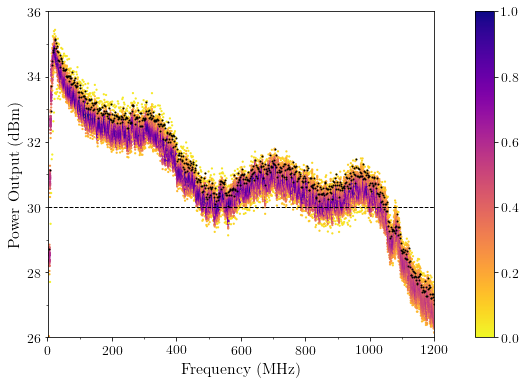

In [125]:
colorMap = []
i = 0
for i in range(int(output_2d.shape[1])):
    gs = gaussian_kde(output_2d[:, i])
    colorMap.extend(gs(output_2d[:, i]))
c = colorMap/np.max(colorMap)
cnorm = matplotlib.colors.Normalize(vmin=np.min(c), vmax = np.max(c))

fig = plt.figure()
fig.set_size_inches((8,6))

gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1])
ax = fig.add_subplot(gs[0,0])
color_ax = plt.subplot(gs[0,1])

sc = ax.scatter(freq_2d.flatten(order='F')/10**6, output_2d.flatten(order='F'), \
                c=c, s=5, edgecolors='', cmap='plasma_r', norm=cnorm, vmin = 0, vmax = 1)
ax.plot(freq/(10**6), WattLine, 'k--', linewidth = 1.0)
ax.scatter(freq/10**6, output['29'], color = 'black', s = 1)
ax.set_ylim(26,36)
ax.set_xlim(1,1200)
ax.set_xlabel('Frequency (MHz)', fontsize = 16)
ax.set_ylabel('Power Output (dBm)', fontsize = 16)
ax.tick_params(labelsize = 14)
ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(mtick.AutoMinorLocator(2))
fig.colorbar(sc, cax=color_ax)
color_ax.tick_params(labelsize = 14)
plt.show()

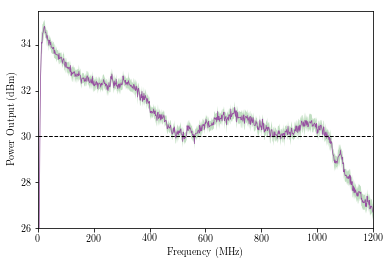

In [26]:
pwr_avg = np.mean(output_2d, axis = 0)
pwr_std = np.std(output_2d, axis = 0)
fig, ax = plt.subplots(1,1)
#plt.plot(freq/(10**6), pwr_avg+pwr_std, 'g-')
#plt.plot(freq/(10**6), pwr_avg-pwr_std, 'g-')
ax.fill_between(freq/(10**6), pwr_avg+pwr_std, pwr_avg-pwr_std, alpha = 0.4)
plt.plot(freq/(10**6), pwr_avg, color = clrs[1], linestyle = '-', linewidth = 0.75)
plt.plot(freq/(10**6), WattLine, 'k--', linewidth = 1.0)
plt.ylim(26,35.5)
plt.xlim(1,1200)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power Output (dBm)')
plt.show()

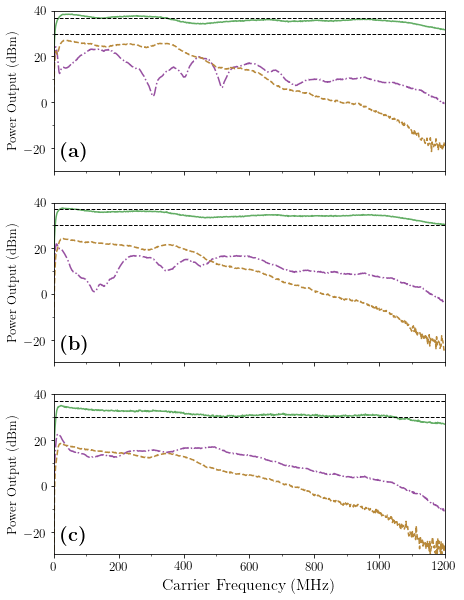

In [150]:
fig = plt.figure()
fig.set_size_inches((7,10))
gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,1])

ax = []
i = 0
for i in range(3):
    if i == 0:
        ax.append(fig.add_subplot(gs[2-i,0]))
    else:
        ax.append(fig.add_subplot(gs[2-i,0], sharex = ax[0]))
        plt.setp(ax[i].get_xticklabels(), visible=False)
    ax[i].plot(freq_1st/(10**6), Harm['1,'+str(i*5)], color = clrs[0], linestyle = '-')
    ax[i].plot(freq_1st/(10**6), Harm['2,'+str(i*5)], color = clrs[1], linestyle = '-.')
    ax[i].plot(freq_1st/(10**6), Harm['3,'+str(i*5)], color = clrs[2], linestyle = '--')
    ax[i].plot(freq/(10**6), WattLine, 'k--', linewidth = 1.0)
    ax[i].plot(freq/(10**6), WattLine2, 'k--', linewidth = 1.0)
    ax[i].set_ylabel('Power Output (dBm)', fontsize = 13)
    ax[i].xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    ax[i].tick_params(labelsize = 13)
    ax[i].set_xlim(1,1200)
    ax[i].set_ylim(-30,40)
#plt.plot(freq_1st/(10**6), WattLine, 'k--')
ax[0].set_xlabel('Carrier Frequency (MHz)', fontsize = 16)
fig.text(.14, .6775, r'\textbf{(a)}', fontsize=20)
fig.text(.14, .41, r'\textbf{(b)}', fontsize=20)
fig.text(.14, .145, r'\textbf{(c)}', fontsize=20)
plt.show()

In [64]:
def pPeak(df, freqs):
    list_ = []
    freq_dict = {'50MHz' : 50*10**6, '100MHz' : 100*10**6, '500MHz' : 500*10**6, '1GHz' : 10**9}
    for index, freq in enumerate(freqs):
        v_sq = np.power(df['v_envl_'+freq], 2)
        p_temp = 10*np.log(v_sq/v_sq[0])
        df['p_pk_'+freq] = p_temp
def envelopes(df, freqs):
    df_temp = pd.DataFrame()
    list_ = []
    freq_dict = {'50MHz' : 50*10**6, '100MHz' : 100*10**6, '500MHz' : 500*10**6, '1GHz' : 10**9}
    for index, freq in enumerate(freqs):
        #analytic_signal = hilbert(df['v_raw_'+freq]-np.mean(df['v_raw_'+freq]))
        bin_size = int(np.ceil((freq_dict[freq]*abs(df['t_raw_'+freq][1]-df['t_raw_'+freq][0]))**(-1))/4)
        filt_size = 12
        filt = np.ones((filt_size,))/filt_size
        sig_in = np.array(df['v_raw_'+freq])
        sig_temp = np.convolve(sig_in, filt, mode = 'valid')
        arg_maxima = argrelextrema(sig_temp, np.greater, order=bin_size)[0]
        arg_minima = argrelextrema(sig_temp, np.less, order=bin_size)[0]
        df_temp['t_'+freq] = df['t_raw_'+freq][max(arg_maxima[0],arg_minima[0]):min(arg_maxima[-1],arg_minima[-1]):]
        sp = UnivariateSpline(df['t_raw_'+freq][arg_maxima], df['v_raw_'+freq][arg_maxima], k=1, s=0)
        df_temp['e+_'+freq] = sp(df_temp['t_'+freq])
        sp = UnivariateSpline(df['t_raw_'+freq][arg_minima], df['v_raw_'+freq][arg_minima], k=1, s=0)
        df_temp['e-_'+freq] = sp(df_temp['t_'+freq])
    df_temp = df_temp.reset_index(drop=True)
    return df_temp

In [3]:
df = pd.DataFrame()
list_ = []
for freq in ['50MHz', '100MHz', '500MHz', '1GHz']:
    for trace in ['raw', 'trig', 'envl']:
        f_name = 'Switch_'+freq+'_'+trace+'.csv'
        df_temp = pd.read_csv(f_name, header=None, usecols=[3,4], names=['t_'+trace+'_'+freq, 'v_'+trace+'_'+freq])
        list_.append(df_temp)
df = pd.concat(list_, axis=1)

In [65]:
df2 = envelopes(df, ['50MHz', '100MHz', '500MHz', '1GHz'])
pPeak(df, ['50MHz', '100MHz', '500MHz', '1GHz'])

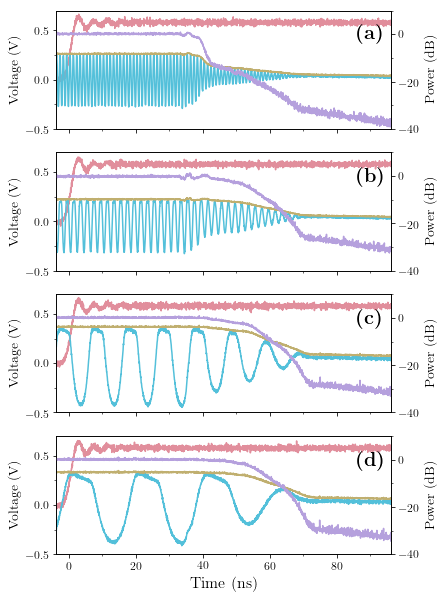

In [133]:
fig = plt.figure()
fig.set_size_inches((6,10))
gs = gridspec.GridSpec(4, 1, height_ratios=[1,1,1,1])

ax = []
twinax = []
freqs = ['50MHz', '100MHz', '500MHz', '1GHz']
i = 0
for i in range(4):
    if i == 0:
        ax.append(fig.add_subplot(gs[3-i,0]))
    else:
        ax.append(fig.add_subplot(gs[3-i,0], sharex = ax[0]))
        plt.setp(ax[i].get_xticklabels(), visible=False)
    for index, trace in enumerate(['trig','raw','envl']):
        ax[i].plot(df['t_'+trace+'_'+freqs[i]][::10]*10**9, df['v_'+trace+'_'+freqs[i]][::10], \
                   color = clrs2[index], linestyle = '-')
    twinax.append(ax[i].twinx())
    twinax[i].plot(df['t_envl_'+freqs[i]][::10]*10**9, df['p_pk_'+freqs[i]][::10], \
                   color = clrs2[3], linestyle = '-')
    #ax[i].plot(df2['t_'+freqs[i]]*10**9, df2['e+_'+freqs[i]], \
    #           color = clrs2[3], linestyle = '-')
    #ax[i].plot(df2['t_'+freqs[i]]*10**9, df2['e-_'+freqs[i]], \
    #           color = clrs2[4], linestyle = '-')
    ax[i].set_ylabel('Voltage (V)', fontsize = 14)
    twinax[i].set_ylabel('Power (dB)', fontsize = 14)
    ax[i].xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    twinax[i].yaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    ax[i].set_ylim(-0.5, 0.7)
    ax[i].tick_params(labelsize = 12)
    twinax[i].set_ylim(-40, 10)
    twinax[i].tick_params(labelsize = 12)
#ax = fig.add_subplot(gs[0,0])
#twinax = ax.twinx()
ax[0].set_xlim(-3.75, 96.2)
ax[0].set_xlabel('Time (ns)', fontsize = 16)
fig.text(.82, .84, r'\textbf{(a)}', fontsize=20)
fig.text(.82, .6425, r'\textbf{(b)}', fontsize=20)
fig.text(.82, .445, r'\textbf{(c)}', fontsize=20)
fig.text(.82, .2475, r'\textbf{(d)}', fontsize=20)
plt.show()

In [135]:
dft = pd.DataFrame()
list_ = []
for pin, atten in [('term', '4V'), ('0dbm', '0V'), ('0dbm', '4V')]:
    f_name = 'unit29_'+pin+'_ext_'+atten+'.DAT'
    df_temp = pd.read_csv(f_name, sep=';', header=None, usecols=[0,1], skiprows=29, \
                          names=['f_'+pin+'_'+atten, 'p_'+pin+'_'+atten])
    list_.append(df_temp)
dft = pd.concat(list_, axis=1)

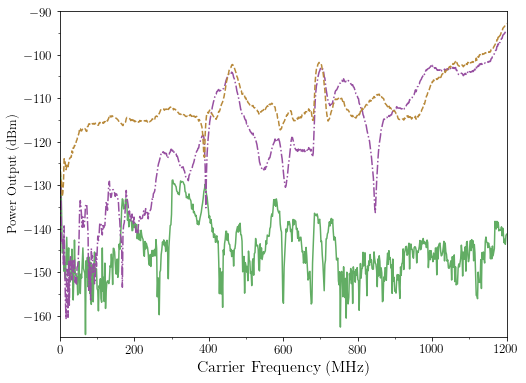

In [146]:
fig = plt.figure()
fig.set_size_inches((8,6))
gs = gridspec.GridSpec(1, 1)

ax = fig.add_subplot(gs[0,0])
ax.plot(dft['f_term_4V']/(10**6), -(Harm['1,0']-dft['p_term_4V']), color = clrs[0], linestyle = '-')
ax.plot(dft['f_0dbm_4V']/(10**6), -(Harm['1,0']-dft['p_0dbm_4V']), color = clrs[1], linestyle = '-.')
ax.plot(dft['f_0dbm_0V']/(10**6), -(Harm['1,0']-dft['p_0dbm_0V']), color = clrs[2], linestyle = '--')
ax.set_ylabel('Power Output (dBm)', fontsize = 13)
ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(mtick.AutoMinorLocator(2))
ax.tick_params(labelsize = 13)
ax.set_xlim(1,1200)
ax.set_ylim(-165,-90)
#plt.plot(freq_1st/(10**6), WattLine, 'k--')
ax.set_xlabel('Carrier Frequency (MHz)', fontsize = 16)
plt.show()